In [67]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("../python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting


# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

rootdirec="/home/kdm2144/"
vcert=stats.norm.interval(.99)[1]

#Region locations
NCA4regions={}
#Northwest (NW): (125°W–111°W, 42°N–49°N)
NCA4regions["NW"]=cdutil.region.domain(longitude=(-125,-111),latitude=(42,49))
#Southwest (SW): (124°W–102°W, 31°N–42°N)
NCA4regions["SW"]=cdutil.region.domain(longitude=(-124,-102),latitude=(31,42))
#Upper Great Plains (GPu): (116°W–95°W, 40°N–49°N)
NCA4regions["GPu"]=cdutil.region.domain(longitude=(-116,-95),latitude=(40,49))
#Lower Great Plains (GPl): (107°W–93°W, 26°N–40°N)
NCA4regions["GPl"]=cdutil.region.domain(longitude=(-107,-93),latitude=(26,40))
#Midwest (MW): (97°W–80°W, 36°N–50°N)
NCA4regions["MW"]=cdutil.region.domain(longitude=(-97,-80),latitude=(36,50))
#Northeast (NE): (82°W–67°W, 37°N–48°N)
NCA4regions["NE"]=cdutil.region.domain(longitude=(-82,-67),latitude=(37,48))
#Southeast (SE): (95°W–76°W, 25°N–39°N)
NCA4regions["SE"]=cdutil.region.domain(longitude=(-95,-76),latitude=(25,39))


external_drive="/home/kdm2144/"


In [35]:
from scipy import signal

def FourierPlot(tas):
    detrend = signal.detrend(tas)
    L = len(tas)
    freqs = np.fft.fftfreq(L)
    tas_fft = np.fft.fft(detrend)
    R = tas_fft.real
    Im = tas_fft.imag
    mag = np.sqrt(R**2+Im**2)
    plt.plot(1/freqs,mag)
def annual_cycle_dominant(tas):
    """Check to see whether the annual cycle is dominant"""
    detrend = signal.detrend(tas)
    L = len(tas)
    freqs = np.fft.fftfreq(L)
    tas_fft = np.fft.fft(detrend)
    R = tas_fft.real
    Im = tas_fft.imag
    mag = np.sqrt(R**2+Im**2)
    the_period = 1./np.abs(freqs[np.argmax(mag)])
    return the_period

def get_dominant_cycle(tas):
    nt,nlat,nlon = tas.shape
    to_mask = MV.zeros((nlat,nlon))
    for i in range(nlat):
        for j in range(nlon):
            to_mask[i,j]=annual_cycle_dominant(tas[:,i,j])
    to_mask.setAxisList(tas.getAxisList()[1:])
    return to_mask
def get_cycle(tas,period=12,return_complex=False):

    L = len(tas)
    freqs = np.fft.fftfreq(L)
    closest = np.abs(freqs-1./period)
    
#    i = np.where(freqs == 1./period)[0]
    i = np.argmin(closest)
   # print(1/freqs[i])
    tas_fft = np.fft.fft(tas)/L
    R = tas_fft.real
    Im = tas_fft.imag
    if return_complex:
        return R[i],Im[i]
    else:
        mag = np.sqrt(R**2+Im**2)
        phase = np.arctan2(Im,R)
        return mag[i],phase[i]
def day_of_peak(phase):
    #make sure phase lies between [0,2pi]
    phase=stats.circmean(phase)
    days=np.arange(365)
    func=np.cos(2*np.pi/12*np.linspace(0,12,365)+phase)
    #return the day of max variable if it's between spring and fall
    #if (phase>np.pi/4) and (phase<7*np.pi/4):
    return float(days[np.argmax(func)])
   # #otherwise winter
   # else:
       # return float(days[np.argmin(func)])
vec_day_of_peak=np.vectorize(day_of_peak)

def day_of_trough(phase):
    #make sure phase lies between [0,2pi]
    phase=stats.circmean(phase)
    days=np.arange(365)
    func=np.cos(2*np.pi/12*np.linspace(0,12,365)+phase)
    #return the day of max variable if it's between spring and fall
    #if (phase>np.pi/4) and (phase<7*np.pi/4):
    return float(days[np.argmin(func)])
   # #otherwise winter
   # else:
       # return float(days[np.argmin(func)])
vec_day_of_trough=np.vectorize(day_of_trough)

In [36]:
import DroughtHelper2 as dh
#from importlib import reload
#reload(dh)

In [37]:
dh.get_ok_models("NW")

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2', 'CESM2-WACCM', 'CanESM5',
       'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3', 'HadGEM3-GC31-LL',
       'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0'], dtype='<U15')

In [38]:
def get_amplitude_and_phase_from_file(fname):
  
    f=cdms.open(fname)
    variable=fname.split("/")[-1].split(".")[0]
    data=f(variable)
    cdutil.setTimeBoundsMonthly(data)
   
    data_year=cdutil.YEAR(data)
    nyears=int(data.shape[0]/12)
    
   

    A=MV.array([get_cycle(data[i*12:12*(i+1)])[0] for i in range(nyears)])
    P=MV.array([get_cycle(data[i*12:12*(i+1)])[1] for i in range(nyears)])
    
        
    A=MV.masked_where(data_year.mask,A)
    A.setAxisList(data_year.getAxisList())
    A.id="amp"

    P=MV.masked_where(data_year.mask,P)
    P.setAxisList(data_year.getAxisList())
    P.id="phase"
    f.close()
    return A,P

In [39]:
def calculate_anomalies():
    if anomaly:
        if scenario.find("hist")>0:
            Aclim=MV.average(A(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Aclim=MV.average(A(time=('2015-1-1','2035-12-31')),axis=1)
        Aanom=cmip5.cdms_clone(A-np.repeat(Aclim.asma()[:,np.newaxis],nyears,axis=1),A)
        Aanom.id="amp_anom"
        if scenario.find("hist")>0:
            Pclim=stats.circmean(P(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Pclim=stats.circmean(P(time=('2015-1-1','2035-12-31')),axis=1)
        
        Panom=cmip5.cdms_clone(vec_day_of_peak(P)-np.repeat(vec_day_of_peak(Pclim)[:,np.newaxis],nyears,axis=1),P)
        Panom.id="phase_anom"
        return Aanom,Panom
    else:
        return A,P

In [40]:
variable="mrsos"
experiment="ssp585"
f=cdms.open("/home/kdm2144/DROUGHT/Maps/"+variable+"."+experiment+".MMA.2015_2100.nc")
test_mrsos=f("mrsos")
f.close()


In [48]:
nmod,nmonths,nlat,nlon=test_mrsos.shape
mma=MV.average(test_mrsos,axis=0)
mma=MV.masked_where(mma==0,mma)

/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


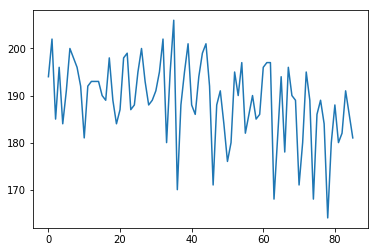

In [46]:
data=mma[:,131,199]
nyears=86
#plt.plot(data[:12].asma())
plt.plot(vec_day_of_trough((np.array([get_cycle(data[ai*12:12*(ai+1)])[1] for ai in range(nyears)]))))


In [66]:

nyears=int(nmonths/12)
A=MV.zeros((nyears,nlat,nlon))
P=MV.zeros((nyears,nlat,nlon))
for i in range(nlat):
    for j in range(nlon):
        if not mma.mask[0,i,j]:
            data=mma[:,i,j]
            if annual_cycle_dominant(data)==12:
                for year in range(nyears):
                    amp,phase=get_cycle(data[year*12:(year+1)*12])
                    A[year,i,j]=amp
                    P[year,i,j]=day_of_trough(phase)


/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


In [74]:
P=MV.masked_where(P==0,P)
yav=cdutil.YEAR(mma)
P.setAxisList(yav.getAxisList())

A=MV.masked_where(A==0,A)

A.setAxisList(yav.getAxisList())

In [98]:
P.id="phase"
A.id="amp"
fw=cdms.open("/home/kdm2144/DROUGHT/Maps/"+variable+"."+experiment+".AmpPhase.2015_2100.nc","w")
fw.write(A)
fw.write(P)
fw.close()

'ssp585'

In [88]:
# Map Stuff
# Some mapping variables
def plot_CONUS(mme_diff,cmap_name=plt.cm.BrBG,vmax=None,vmin=None):
    lono=mme_diff.getLongitude()[:]
    lato=mme_diff.getLatitude()[:]
    lon,lat=np.meshgrid(lono,lato)
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',\
            name='admin_1_states_provinces_lines',\
            scale='50m',\
            facecolor='none')
    extent_lonlat = (-125, -70, 22, 50)

    #clevs = np.array([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,.3,.4,.5,.6])*2.5
    if vmin is None:
        vmin=np.percentile(mme_diff.compressed(),5)
    if vmax is None:
        vmax=np.percentile(mme_diff.compressed(),95)
    clevs=np.linspace(vmin,vmax,13)
    clevs_units=clevs.copy()
    nmap = plt.cm.get_cmap(name=cmap_name,lut=clevs.size-1)

    ocean_color = np.float64([209,230,241])/255

    fig = plt.figure(figsize=(12, 12),facecolor="white")
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-100, central_latitude=25, globe=None))
    m = ax.contourf(lon, lat, mme_diff,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
    ax.coastlines()
    ax.set_global()
    ax.set_extent(extent_lonlat, crs=ccrs.PlateCarree())
    #ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.LAND,color='w',zorder=0,edgecolor='k')
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=1)
    #ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=2,edgecolor='k')
    #ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
     #horizontalalignment='center', verticalalignment='center',)
    #ax.text(-122,17,ssp_txt,transform=ccrs.PlateCarree(),fontsize=28,fontweight="normal", \
     #horizontalalignment='center', verticalalignment='center',)
    cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
    cbar.ax.tick_params(labelsize=24)

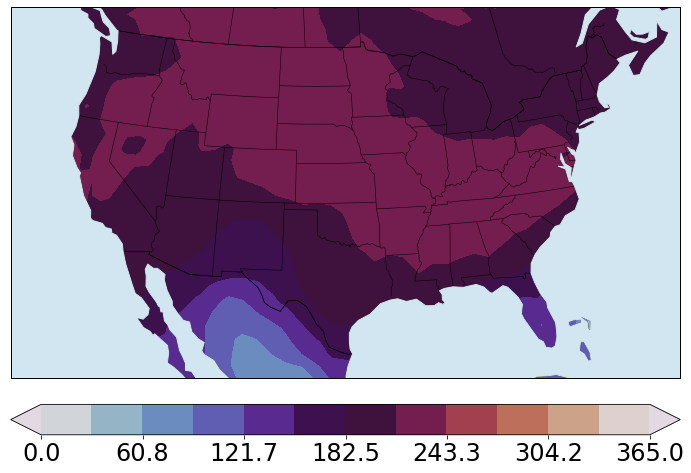

In [100]:
Pav=cmip5.cdms_clone(stats.circmean(P.asma(),high=365,low=0,axis=0),P[0])

plot_CONUS(Pav,cmap_name=cm.twilight,vmin=0,vmax=365)

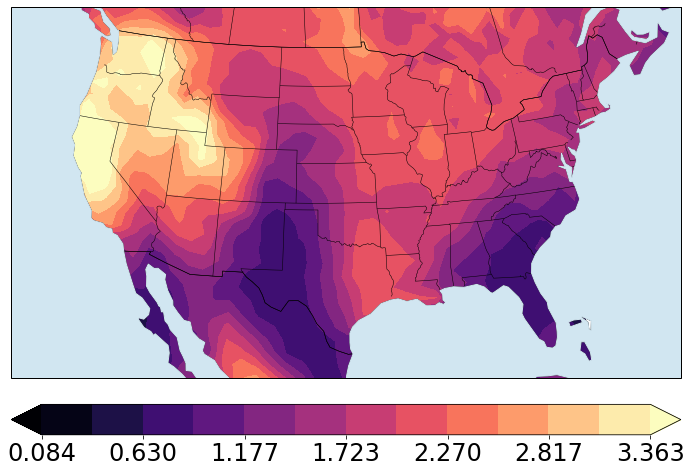

In [90]:
mme_diff=MV.average(A,axis=0)
plot_CONUS(mme_diff,cmap_name=cm.magma)

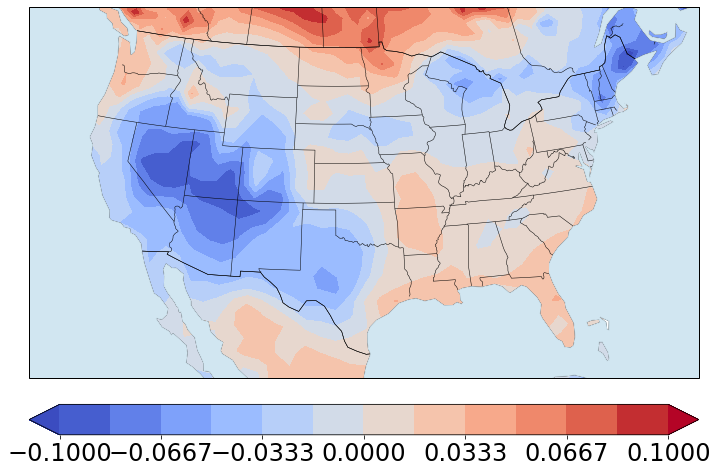

In [103]:
Atrends=cmip5.get_linear_trends(A)
plot_CONUS(Atrends,vmin=-0.1,vmax=0.1,cmap_name=cm.coolwarm)

/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


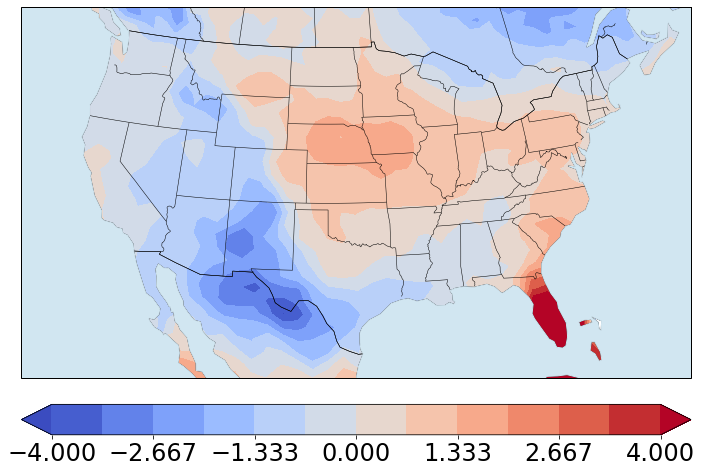

In [101]:
Ptrends=cmip5.get_linear_trends(P)
plot_CONUS(Ptrends,vmin=-4,vmax=4,cmap_name=cm.coolwarm)

In [52]:
def get_amplitude_and_phase(variable,region,scenario="hist+ssp585",anomaly=True,raw=False):
    data=dh.TOE(variable,region)

    if scenario.find("+")>0:
        ssp=scenario.split("+")[-1]
        hssp=data.splice_historical(ssp)
    else:
        hssp=data.ensemble_average(scenario)
    hssp_year=cdutil.YEAR(hssp)
    nyears=int(hssp.shape[1]/12)
    nmod=int(hssp.shape[0])
    A=MV.zeros((nmod,nyears))
    P=MV.zeros((nmod,nyears))

    for counter in range(nmod):
        x=hssp[counter]
        amps=[get_cycle(x[i*12:12*(i+1)])[0] for i in range(nyears)]
        phases=[get_cycle(x[i*12:12*(i+1)])[1] for i in range(nyears)]
        A[counter]=amps
        P[counter]=phases
    A=MV.masked_where(hssp_year.mask,A)
    A.setAxisList(hssp_year.getAxisList())
    A.id="amp"

    P=MV.masked_where(hssp_year.mask,P)
    P.setAxisList(hssp_year.getAxisList())
    P.id="phase"

    if anomaly:
        if scenario.find("hist")>0:
            Aclim=MV.average(A(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Aclim=MV.average(A(time=('2015-1-1','2035-12-31')),axis=1)
        Aanom=cmip5.cdms_clone(A-np.repeat(Aclim.asma()[:,np.newaxis],nyears,axis=1),A)
        Aanom.id="amp_anom"
        if scenario.find("hist")>0:
            Pclim=stats.circmean(P(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Pclim=stats.circmean(P(time=('2015-1-1','2035-12-31')),axis=1)
        
        Panom=cmip5.cdms_clone(vec_day_of_peak(P)-np.repeat(vec_day_of_peak(Pclim)[:,np.newaxis],nyears,axis=1),P)
        Panom.id="phase_anom"
        if raw:
            return A,Aanom,P,Panom
        else:
            return Aanom,Panom
    else:
        return A,P





In [53]:
def generate_all_amplitudes_phases():

    base_read_dir=external_drive+"DROUGHT/NCA4/"
    base_write_dir=external_drive+"DROUGHT/AmplitudePhase/"

    regions=NCA4regions.keys()
   
    allvariables=['tas', 'mrro', 'mrros', 'mrso',"mrsos", 'pr', 'evspsbl', 'prsn']
    
    experiments=["piControl","historical","ssp126","ssp585","ssp370","ssp245"]
    
    for region in regions:
        for variable in allvariables:
            print(variable)
            for experiment in experiments:
                print(experiment)
                os.makedirs(os.path.join(base_write_dir, region,variable,experiment),exist_ok=True)
                readdirec=os.path.join(base_read_dir, region,variable,experiment)+"/"
                fnames=glob.glob(readdirec+"*")
                
                for fname in fnames:
                    fwritename=fname.replace("NCA4","AmplitudePhase")
                    if fwritename not in glob.glob(os.path.join(base_write_dir, region,variable,experiment)+"/*"):
                        print(fwritename)
                        A,P=get_amplitude_and_phase_from_file(fname)
                        fwrite=cdms.open(fwritename,"w")
                        fwrite.write(A)
                        fwrite.write(P)
                        fwrite.close()
                    


In [54]:
#generate_all_amplitudes_phases()

In [55]:
def ensemble_average_data(data,models=None):

    nens,ntime=data.shape

    if models is None:
        #models=np.unique([fname.split(".")[2] for fname in cmip5.models(data)])
        models=get_ok_models("NW")

    nmod=len(models)

    EnsembleAverage=np.ma.zeros((nmod,ntime))+1.e20

    #fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem))
    fnames=cmip5.models(data)
    
    counter=0
    for model in models:
        #fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
        I=np.where([x.split(".")[2]==model for x in fnames])[0]
        if len(I)>0:
            EnsembleAverage[counter]=np.ma.average(data.asma()[I],axis=0)

        else:
            
            print("missing data for "+model)
        counter+=1

    EnsembleAverage=MV.masked_where(np.abs(EnsembleAverage)>1.e10,EnsembleAverage)
    EnsembleAverage=MV.masked_where(np.isnan(EnsembleAverage),EnsembleAverage)
    EnsembleAverage=MV.array(EnsembleAverage)
    EnsembleAverage.setAxis(1,data.getTime())
    modax=cmip5.make_model_axis(models)
    EnsembleAverage.setAxis(0,modax)
    cdutil.setTimeBoundsMonthly(EnsembleAverage)    

    return EnsembleAverage

In [56]:
def splice_data(hdata,sspdata):
    scenario=cmip5.models(sspdata)[0].split("/")[-2]
    sspmodels=[fname.split(".")[2] for fname in cmip5.models(sspdata)]
    ssprips=[fname.split(".")[3] for fname in cmip5.models(sspdata)]
    sspids=[]
    for mod,rip in zip(sspmodels,ssprips):
        sspids+=[mod+"."+rip]


    hmodels=[fname.split(".")[2] for fname in cmip5.models(hdata)]
    hrips=[fname.split(".")[3] for fname in cmip5.models(hdata)]
    hids=[mod+"."+rip for mod,rip in zip(hmodels,hrips)]


    lenhist=hdata.shape[1]
    lenssp=sspdata.shape[1]
    intersect=np.intersect1d(np.array(hids),np.array(sspids))
    nmod=len(intersect)
    spliced=MV.zeros((nmod,lenhist+lenssp))
    counter=0
    splicedmods=[]
    for pr in intersect:
        i=hids.index(pr)

        j=sspids.index(pr)
        dat=MV.concatenate((hdata[i],sspdata[j]))
        spliced[counter]=dat
        splicedmods+=[cmip5.models(hdata)[i].replace("historical","historical_"+scenario)]
        #print(cmip5.models(hdata)[i])
        counter+=1
    modax=cmip5.make_model_axis(splicedmods)
    nyears=lenhist+lenssp
    tax=cdms.createAxis(np.arange(6,nyears*12,12))
    tax.designateTime()
    tax.id="time"
    htax=hdata.getTime()
    for att in htax.attributes.keys():
        setattr(tax,att,htax.attributes[att])
    spliced.setAxisList([modax,tax])
    spliced.id=hdata.id
    return spliced

In [57]:
def get_ensemble_filenames(variable,region,experiment,readstem=external_drive+"DROUGHT/NCA4/"):
    fnames=[]
    for model in dh.get_ok_models(region):
        fnames+=glob.glob(readstem+region+"/"+variable+"/"+experiment+"/"+variable+"."+experiment+"."+model+".*")
    return fnames
def get_available_models(variable,experiment,region):
    return np.unique([x.split(".")[-3] for x in glob.glob(external_drive+"DROUGHT/NCA4/"+region+"/"+variable+"/"+experiment+"/*")])
def get_ok_models(region,variables=None):
    models=[x.split("_fx_")[-1].split(".")[0] for x in glob.glob(external_drive+"DROUGHT/fixedvar/sftlf*")]
    if variables is None:
        #variables=['tas', 'mrro', 'mrros', 'mrso', 'pr',"evspsbl","mrsos","prsn"] #add mrsos, evspsbl and prsn when they download
        variables=["evspsbl"]
    experiments=["piControl","historical","ssp585"] #require at least 1 ens member in each of these experiments
    for variable in variables:
        for experiment in experiments:
            models=np.intersect1d(models,get_available_models(variable,experiment,region))
    return models
class AmpPhase():
    def __init__(self,variable,region,verbose=False):
        self.variable=variable
        self.region=region
        self.verbose=verbose
        self.readstem = external_drive+"DROUGHT/AmplitudePhase/"
    def get_ensemble(self,experiment):
        if not hasattr(self,experiment):
            if experiment != "piControl":
                fnames=get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem)
                nfiles=len(fnames)
                i=0
                fil=fnames[i]
                f=cdms.open(fil)
                ampdata=f("amp")
                phasedata=f("phase")
                tax=ampdata.getTime()
                #if experiment != "piControl":
                ntime=len(tax)

                all_ampdata=MV.zeros((nfiles,ntime))+1.e20
                all_phasedata=MV.zeros((nfiles,ntime))+1.e20
                all_ampdata[i]=ampdata[:ntime]
                all_phasedata[i]=phasedata[:ntime]
                f.close()
                for i in range(nfiles)[1:]:
                    fil=fnames[i]
                    f=cdms.open(fil)
                    ampdata=f("amp")
                    phasedata = f("phase")
                    if len(ampdata.getTime())==ntime:
                        all_ampdata[i]=ampdata
                        all_phasedata[i]=phasedata
                    elif len(ampdata.getTime())>ntime:
                        all_ampdata[i]=ampdata[:ntime]
                        all_phasedata[i]=phasedata[:ntime]
                    else:
                        badlength=len(ampdata.getTime())
                        all_ampdata[i,:badlength]=ampdata
                        all_phasedata[i,:badlength]=phasedata
                    f.close()
                all_ampdata=MV.masked_where(np.abs(all_ampdata)>1.e10,all_ampdata)
                all_ampdata.setAxis(1,tax)    
                modax=cmip5.make_model_axis(fnames)
                all_ampdata.setAxis(0,modax)
                
                all_phasedata=MV.masked_where(np.abs(all_phasedata)>1.e10,all_phasedata)
                all_phasedata.setAxis(1,tax)    
                modax=cmip5.make_model_axis(fnames)
                all_phasedata.setAxis(0,modax)
                #convert soil moisture to z scores
                # if self.variable in ["mrso","mrsos"]:
                #     alldata=self.standardize_zcore(alldata)
                # else:
                #     alldata=self.convert_to_percentage(alldata)
                setattr(self,experiment,{})
                getattr(self,experiment)["amp"]=MV.masked_where(np.abs(all_ampdata)>1.e10,all_ampdata)
                getattr(self,experiment)["phase"]=MV.masked_where(np.abs(all_phasedata)>1.e10,all_phasedata)
            else:
                all_ampdata,all_phasedata=self.concatenate_piControl()
                setattr(self,experiment,{})
                getattr(self,experiment)["amp"]=MV.masked_where(np.abs(all_ampdata)>1.e10,all_ampdata)
                getattr(self,experiment)["phase"]=MV.masked_where(np.abs(all_phasedata)>1.e10,all_phasedata)
                
    def concatenate_piControl(self,season=None,compressed=False):
        experiment="piControl"
        fnames=sorted(get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem))
        #models=sorted(self.ensemble_dict.keys())
        models=dh.get_ok_models(self.region)
        
        nmod=len(models)
        print(nmod)
        ntimes=[]
        model_names=[]
        #Loop over without loading data to figure out the shortest length control run
        for model in models:
           # print(model)
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                first_member=int(I[0])
       
                fname=fnames[first_member]
          
                model_names+=[fname]
                f=cdms.open(fname)
                ntimes+=[int(f["amp"].shape[0])]
                f.close()
        L=np.min(ntimes)
        #Set the time axis to be the time axis of the shortest control rin
        imin=np.argmin(ntimes)

        fshortest=model_names[imin]
        f=cdms.open(fshortest)
        tax=f("amp").getTime()
        tax.id='time'
        tax.designateTime()
        f.close()
        #Load data
        #SingleMember=np.ma.zeros((len(model_names),L))+1.e20
        SingleMember_amp=np.ma.zeros((nmod,L))+1.e20
        SingleMember_phase=np.ma.zeros((nmod,L))+1.e20
        i=0
        make_modax=[]
        for model in models:
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                first_member=I[0]
                fname=fnames[first_member]
                f=cdms.open(fname)
                ampdata=f("amp")
                SingleMember_amp[i]=ampdata[:L]
                make_modax+=[fname]
                phasedata=f("phase")
                SingleMember_phase[i]=phasedata[:L]
                i+=1
            else:
                if self.verbose:
                    print("No piControl data for "+model+" "+self.variable)
                make_modax+=["NODATA.piControl."+model]
            f.close()
        
        
        SingleMember_amp=MV.masked_where(np.abs(SingleMember_amp)>1.e10,SingleMember_amp)
        SingleMember_amp=MV.array(SingleMember_amp)
        SingleMember_amp.setAxis(1,tax)
        SingleMember_amp.setAxis(0,cmip5.make_model_axis(make_modax))
        ###KLUDGE: FIRST YEAR IS ZERO- FIX THIS IN DOWNLOADER
        SingleMember_amp=MV.masked_where(SingleMember_amp==0,SingleMember_amp)
        
        SingleMember_phase=MV.masked_where(np.abs(SingleMember_phase)>1.e10,SingleMember_phase)
        SingleMember_phase=MV.array(SingleMember_phase)
        SingleMember_phase.setAxis(1,tax)
        SingleMember_phase.setAxis(0,cmip5.make_model_axis(models))
        ###KLUDGE: FIRST YEAR IS ZERO- FIX THIS IN DOWNLOADER
        SingleMember_phase=MV.masked_where(SingleMember_phase==0,SingleMember_phase)
        cdutil.setTimeBoundsMonthly(SingleMember_amp)
        cdutil.setTimeBoundsMonthly(SingleMember_phase)
        
        return SingleMember_amp,SingleMember_phase
    def ensemble_average(self,experiment):
        self.get_ensemble(experiment)
        amp_data=getattr(self,experiment)["amp"]
        phase_data=getattr(self,experiment)["phase"]
        nens,ntime=amp_data.shape
        #models=sorted(self.ensemble_dict.keys())
        #models=get_ok_models(self.region,variables=[self.variable])
        models=dh.get_ok_models(self.region)
        nmod=len(models)
       # print("Number of models is", nmod)
        EnsembleAverage_amp=np.ma.zeros((nmod,ntime))+1.e20
        EnsembleAverage_phase=np.ma.zeros((nmod,ntime))+1.e20
        fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem))
        counter=0
        for model in models:
            #fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                EnsembleAverage_amp[counter]=np.ma.average(amp_data.asma()[I],axis=0)
                EnsembleAverage_phase[counter]=stats.circmean(phase_data.asma()[I],axis=0)
            else:
                if self.verbose:
                    print("missing data for "+model+" "+self.variable+" "+experiment)
            counter+=1
            
        EnsembleAverage_amp=MV.masked_where(np.abs(EnsembleAverage_amp)>1.e10,EnsembleAverage_amp)
        EnsembleAverage_amp=MV.masked_where(np.isnan(EnsembleAverage_amp),EnsembleAverage_amp)
        EnsembleAverage_amp=MV.array(EnsembleAverage_amp)
        EnsembleAverage_amp.setAxis(1,amp_data.getTime())
        modax=cmip5.make_model_axis(models)
        EnsembleAverage_amp.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(EnsembleAverage_amp)    
        
        EnsembleAverage_phase=MV.masked_where(np.abs(EnsembleAverage_phase)>1.e10,EnsembleAverage_phase)
        EnsembleAverage_phase=MV.masked_where(np.isnan(EnsembleAverage_phase),EnsembleAverage_phase)
        EnsembleAverage_phase=MV.array(EnsembleAverage_phase)
        EnsembleAverage_phase.setAxis(1,phase_data.getTime())
    
        EnsembleAverage_phase.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(EnsembleAverage_phase)    
        
        setattr(self,experiment+"_average",{})
        getattr(self,experiment+"_average")["amp"]=EnsembleAverage_amp
        getattr(self,experiment+"_average")["phase"] = EnsembleAverage_phase
        
    
       
    def anomalize(self,experiment):
        if not hasattr(self,experiment):
            
            self.get_ensemble(experiment)
          
                
        data=getattr(self,experiment)
        if not hasattr(self,"historical_average"):
            self.ensemble_average("historical")
        hist=getattr(self,"historical_average")
        
        Ahist=hist["amp"]
        Aclim=MV.average(Ahist(time=('1980-1-1','2014-12-31')),axis=1)
        A=data["amp"]
        Aanom=np.ma.zeros(A.shape)+1.e20
        
        Phist=hist["phase"]
        Pclim=stats.circmean(Phist(time=('1980-1-1','2014-12-31')),axis=1)
        P=data["phase"]
        Panom=np.ma.zeros(P.shape)+1.e20
        
        datamodels=cmip5.models(A)
        histmodels=cmip5.models(Ahist)
        nmod,nyears=A.shape
        for i in range(nmod):
            j=histmodels.index(datamodels[i].split(".")[2])
            Aanom[i]=A[i]-Aclim[j]
            
            climpeak=day_of_peak(Pclim[j])
            

            thisyear_peak=vec_day_of_peak(P[i])
            
            climtrough=day_of_trough(Pclim[j])
            

            thisyear_trough=vec_day_of_trough(P[i])
            pk=thisyear_peak-climpeak
            trh=thisyear_trough-climtrough
            anom=np.where(np.abs(pk) > np.abs(trh), trh, pk)
            
            Panom[i]=anom
            
        Aanom=MV.masked_where(A.mask,Aanom)
        Aanom=cmip5.cdms_clone(Aanom,A)
        Aanom.id="amp_anom"
        
        
        Panom=MV.masked_where(P.mask,Panom)
        Panom=cmip5.cdms_clone(Panom,P)
        Panom.id="phase_anom"
        
        getattr(self,experiment)["amp_anom"]=Aanom
        getattr(self,experiment)["phase_anom"]=Panom
        
    def end_of_century(self):
        P={}
        A={}
        self.anomalize("historical")
        self.anomalize("ssp585")
        self.anomalize("ssp370")
        self.anomalize("ssp245")
        self.anomalize("ssp126")
        self.anomalize("piControl")
        
        piC=self.piControl["amp_anom"]
        noise=DA_tools.concatenate_this(piC,compressed=True)
        



        ssp1data=MV.average(ensemble_average_data(self.ssp126["amp_anom"]),axis=0)
        ssp3data=MV.avdata=MV.average(ensemble_average_data(self.ssp370["amp_anom"]),axis=0)

        ssp2data=MV.average(ensemble_average_data(self.ssp245["amp_anom"]),axis=0)
        ssp5data=MV.average(ensemble_average_data(self.ssp585["amp_anom"]),axis=0)
        slopes=dh.bootstrap_slopes(noise,len(ssp5data.getTime()))
        #A["noise"]=slopes
        A["noise"]=np.ma.std(slopes)
        for scenario in ["ssp126","ssp245","ssp370","ssp585"]:
            data=MV.average(ensemble_average_data(getattr(self,scenario)["amp_anom"]),axis=0)
            A[scenario]=float(cmip5.get_linear_trends(data))

        



        ssp1data=MV.average(ensemble_average_data(self.ssp126["phase_anom"]),axis=0)
        ssp3data=MV.avdata=MV.average(ensemble_average_data(self.ssp370["phase_anom"]),axis=0)

        ssp2data=MV.average(ensemble_average_data(self.ssp245["phase_anom"]),axis=0)
        ssp5data=MV.average(ensemble_average_data(self.ssp585["phase_anom"]),axis=0)

        piC=self.piControl["phase_anom"]
        noise=DA_tools.concatenate_this(piC)
        slopes=dh.bootstrap_slopes(noise,len(ssp5data.getTime()))
        
        #P["noise"]=slopes
        P["noise"]=np.ma.std(slopes)
        for scenario in ["ssp126","ssp245","ssp370","ssp585"]:
            data=MV.average(ensemble_average_data(getattr(self,scenario)["phase_anom"]),axis=0)
            P[scenario]=float(cmip5.get_linear_trends(data))
        return A,P
    
    def trend_significance(self,start,stop):
        P={}
        A={}
        self.anomalize("historical")
        self.anomalize("ssp585")
        self.anomalize("ssp370")
        self.anomalize("ssp245")
        self.anomalize("ssp126")
        self.anomalize("piControl")
        
        piC=self.piControl["amp_anom"]
        noise=DA_tools.concatenate_this(piC)
        



        ssp1data=MV.average(ensemble_average_data(self.ssp126["amp_anom"]),axis=0)(time=(start,stop))
        ssp3data=MV.avdata=MV.average(ensemble_average_data(self.ssp370["amp_anom"]),axis=0)(time=(start,stop))

        ssp2data=MV.average(ensemble_average_data(self.ssp245["amp_anom"]),axis=0)(time=(start,stop))
        ssp5data=MV.average(ensemble_average_data(self.ssp585["amp_anom"]),axis=0)(time=(start,stop))
        
        slopes=dh.bootstrap_slopes(noise,len(ssp5data.getTime()))

        #A["noise"]=slopes
        A["noise"]=np.ma.std(slopes)
        for scenario in ["ssp126","ssp245","ssp370","ssp585"]:
            data=MV.average(ensemble_average_data(getattr(self,scenario)["amp_anom"]),axis=0)
            A[scenario]=float(cmip5.get_linear_trends(data))

        



        ssp1data=MV.average(ensemble_average_data(self.ssp126["phase_anom"]),axis=0)(time=(start,stop))
        ssp3data=MV.avdata=MV.average(ensemble_average_data(self.ssp370["phase_anom"]),axis=0)(time=(start,stop))

        ssp2data=MV.average(ensemble_average_data(self.ssp245["phase_anom"]),axis=0)(time=(start,stop))
        ssp5data=MV.average(ensemble_average_data(self.ssp585["phase_anom"]),axis=0)(time=(start,stop))

        piC=self.piControl["phase_anom"]
        noise=DA_tools.concatenate_this(piC)
        slopes=dh.bootstrap_slopes(noise,len(ssp5data.getTime()))
        
        #P["noise"]=slopes
        P["noise"]=np.ma.std(slopes)
        for scenario in ["ssp126","ssp245","ssp370","ssp585"]:
            data=MV.average(ensemble_average_data(getattr(self,scenario)["phase_anom"]),axis=0)
            P[scenario]=float(cmip5.get_linear_trends(data))
        
        return A,P



In [58]:
def make_sn_dict():
    SN={}
    for region in NCA4regions.keys():
        SN[region]={}
        for variable in ["tas","mrro","mrros","mrso","mrsos","pr","evspsbl","prsn"]:
            SN[region][variable]={}
            X=AmpPhase(variable,region)
            A,P=X.end_of_century()
            SN[region][variable]["amp"]=A
            SN[region][variable]["phase"]=P
    import pickle
    with open("SNamp_phase.pickle","wb") as handle:
        pickle.dump(SN,handle,protocol=pickle.HIGHEST_PROTOCOL)        

In [59]:
import pickle
with open("SNamp_phase.pickle", 'rb') as handle:
    unserialized_data = pickle.load(handle)


In [60]:
import datetime
def time_of_year(day):
    dt=datetime.datetime(1950,1,1)
    deltat=datetime.timedelta(days=day)
    test=dt+deltat
    return str(test.month)+"-"+str(test.day)

In [61]:
def set_up_axis():
    fig3=plt.figure(figsize=(20,8))
    gs = fig3.add_gridspec(2, 12)
    ax1=fig3.add_subplot(gs[0,0:3])
    ax2=fig3.add_subplot(gs[0,3:6])
    ax3=fig3.add_subplot(gs[0,6:9])
    ax4=fig3.add_subplot(gs[0,9:])
    ax5=fig3.add_subplot(gs[1,0:4])
    ax6=fig3.add_subplot(gs[1,4:8])
    ax7=fig3.add_subplot(gs[1,8:])
    d={}
    d["NW"]=ax1
    d["GPu"]=ax2
    d["MW"]=ax3
    d["NE"]=ax4
    d["SW"]=ax5
    d["GPl"]=ax6
    d["SE"]=ax7
    plt.tight_layout()
    return d

def colorscenario(scenario):
    d={}
    d["ssp126"] = "b"
    d["ssp245"] = "g"
    d["ssp370"] = "orange"
    d["ssp585"] = "r"
    return(d[scenario])

In [63]:
def SN_bar(region,ty,ax=None,thresh=.9):
    pthresh=stats.norm.interval(thresh)[1]
    with open("SNamp_phase.pickle", 'rb') as handle:
        unserialized_data = pickle.load(handle)
   
    if ax is None:
            fig=plt.figure()
            ax=fig.add_subplot(111)
 
   
        

    
    variables=['pr', 'prsn','evspsbl','mrro', 'mrros', 'mrso', 'mrsos']#,"tas" ]
    
    counter=0
    labels=[]
    varx=0
    d={}
    for scenario in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        d[scenario]=[]
        for variable in variables:

            signal=unserialized_data[region][variable][ty][scenario]
            noise=unserialized_data[region][variable][ty]["noise"]

            endcen=signal/noise
            
            

        #find the data if it exists
            
            d[scenario]+=[endcen]
       # d[scenario]=np.array(d[scenario])
       # d[scenario]=MV.masked_where(d[scenario]>1.e10,d[scenario])

    for variable in variables:
        i=variables.index(variable)
        if np.abs(d["ssp585"][i])<stats.norm.interval(.66)[1]:
            for scenario in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
                d[scenario][i]=0
    N=len(d["ssp126"])
   
    
    #ind = np.arange(5*N)[seasi::5]   # the x locations for the groups
    ind=np.arange(N)
    width = 0.35       # the width of the bars: can also be len(x) sequence

    ax.plot(ind,np.ma.masked_where(np.array(d["ssp126"])!=0,np.array(d["ssp126"])),"kx")
    p1 = ax.bar(ind, d['ssp126'], width,color=colorscenario("ssp126"))
    p2 = ax.bar(ind, np.array(d['ssp245'])-np.array(d["ssp126"]), width,
                 bottom=d['ssp126'],color=colorscenario("ssp245"))
    p3 = ax.bar(ind, np.array(d['ssp370'])-np.array(d["ssp245"]), width,
                 bottom=d['ssp245'],color=colorscenario("ssp370"))
    p4 = ax.bar(ind, np.array(d['ssp585'])-np.array(d["ssp370"]), width,
                 bottom=d['ssp370'],color=colorscenario("ssp585"))
        #p3 = plt.bar(ind, d['ssp370'], width,
                     #bottom=d['ssp245'])
        #p4 = plt.bar(ind, d['ssp585'], width,
                    # bottom=d['ssp370'])
        #plt.xticks(np.arange(0,N*4,4),variables)
    #for x in np.arange(5*N)[::5][1:]:
        #ax.axvline(x,c="k")
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(variables)
    #plt.axhline(0,ls=":",c="k")
    
    #axtop=ax.twiny()
    #axtop.set_xticks(np.arange(5*N))
    #axtop.set_xticklabels(toplabs)
    #axtop.xaxis.set_ticks_position("top")
    #axtop.xaxis.set_tick_params(rotation=90)



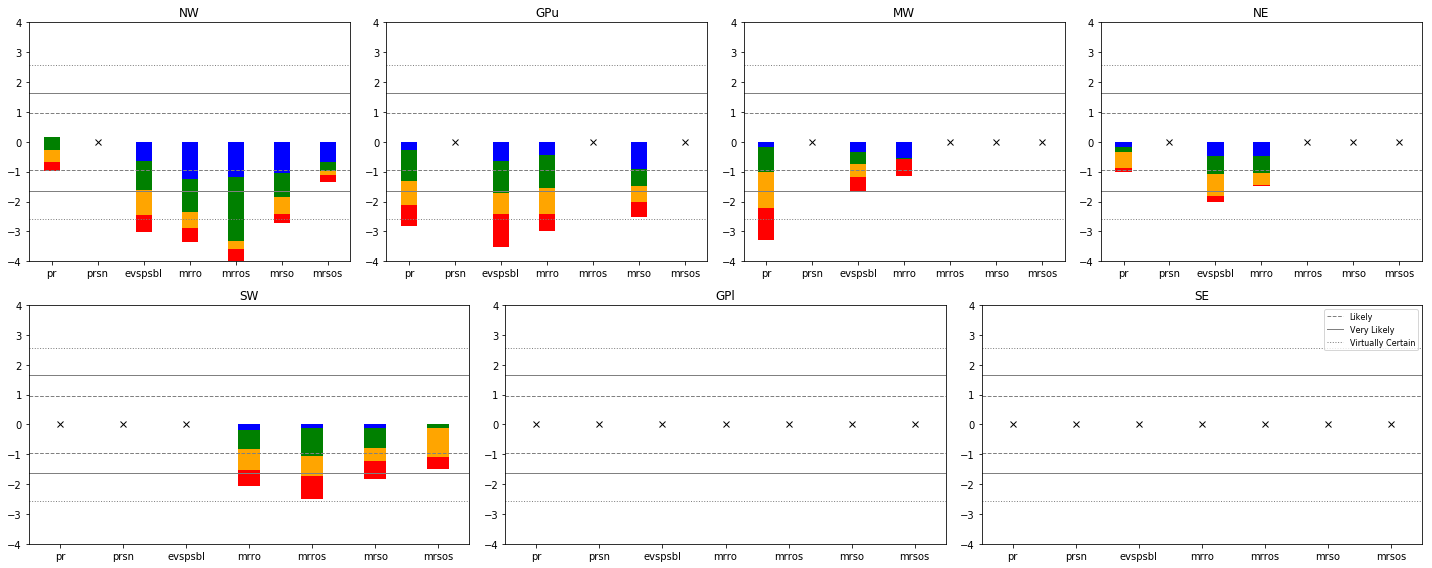

In [67]:
axesdict=set_up_axis()
for region in NCA4regions.keys():
    SN_bar(region,"phase",ax=axesdict[region])
    axesdict[region].set_title(region)
    axesdict[region].set_ylim(-4,4)
   #Confidence Intervals
    axesdict[region].axhline(stats.norm.interval(.66)[1],c=cm.gray(.5),lw=1,ls="--")
    axesdict[region].axhline(stats.norm.interval(.9)[1],c=cm.gray(.5),lw=1)
    axesdict[region].axhline(stats.norm.interval(.99)[1],c=cm.gray(.5),lw=1,ls=":")
    if region != "SE":
        axesdict[region].axhline(stats.norm.interval(.9)[0],c=cm.gray(.5),lw=1)
        axesdict[region].axhline(stats.norm.interval(.99)[0],c=cm.gray(.5),lw=1,ls=":")
        axesdict[region].axhline(stats.norm.interval(.66)[0],c=cm.gray(.5),lw=1,ls="--")
    else:
        axesdict[region].axhline(stats.norm.interval(.66)[0],c=cm.gray(.5),lw=1,ls="--",label="Likely")
        axesdict[region].axhline(stats.norm.interval(.9)[0],c=cm.gray(.5),lw=1,label="Very Likely")
        axesdict[region].axhline(stats.norm.interval(.99)[0],c=cm.gray(.5),lw=1,ls=":",label="Virtually Certain")
        axesdict[region].legend(loc=0,fontsize=8)
plt.tight_layout()
plt.savefig("Phase_SN_no_tas.png")

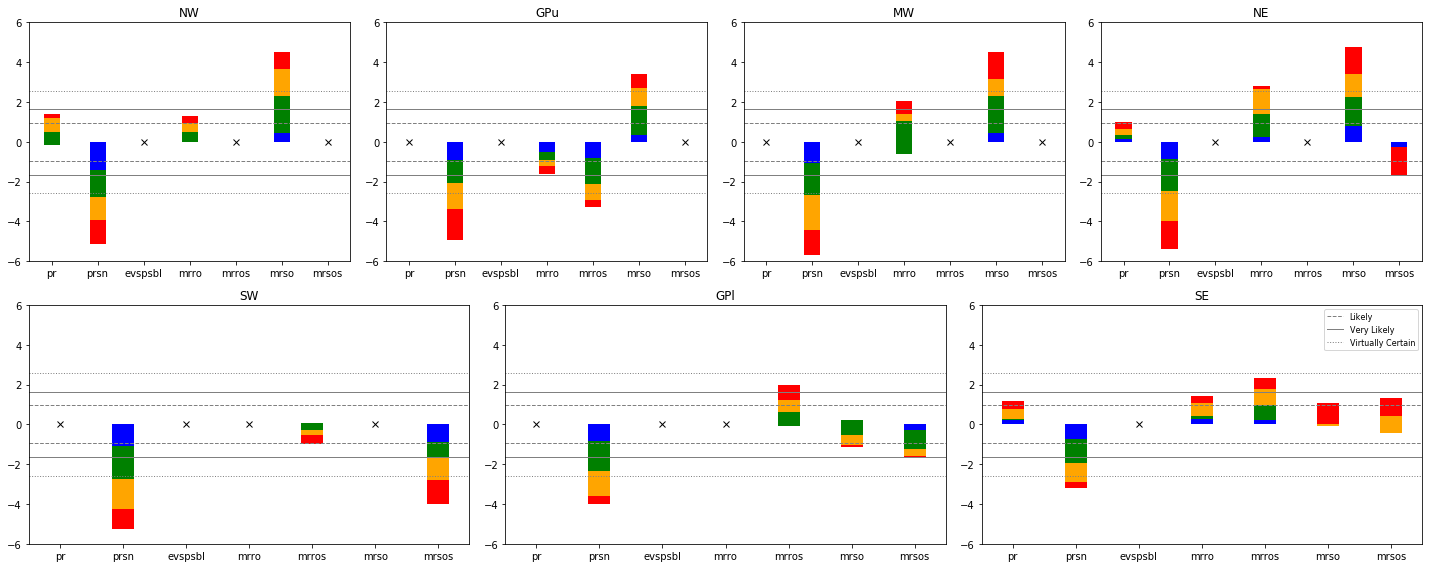

In [66]:
axesdict=set_up_axis()
for region in NCA4regions.keys():
    SN_bar(region,"amp",ax=axesdict[region])
    axesdict[region].set_title(region)
    axesdict[region].set_ylim(-6,6)
    #Confidence Intervals
    axesdict[region].axhline(stats.norm.interval(.66)[1],c=cm.gray(.5),lw=1,ls="--")
    axesdict[region].axhline(stats.norm.interval(.9)[1],c=cm.gray(.5),lw=1)
    axesdict[region].axhline(stats.norm.interval(.99)[1],c=cm.gray(.5),lw=1,ls=":")
    if region != "SE":
        axesdict[region].axhline(stats.norm.interval(.9)[0],c=cm.gray(.5),lw=1)
        axesdict[region].axhline(stats.norm.interval(.99)[0],c=cm.gray(.5),lw=1,ls=":")
        axesdict[region].axhline(stats.norm.interval(.66)[0],c=cm.gray(.5),lw=1,ls="--")
    else:
        axesdict[region].axhline(stats.norm.interval(.66)[0],c=cm.gray(.5),lw=1,ls="--",label="Likely")
        axesdict[region].axhline(stats.norm.interval(.9)[0],c=cm.gray(.5),lw=1,label="Very Likely")
        axesdict[region].axhline(stats.norm.interval(.99)[0],c=cm.gray(.5),lw=1,ls=":",label="Virtually Certain")
        axesdict[region].legend(loc=0,fontsize=8)
plt.tight_layout()
plt.savefig("Amp_SN_no_tas.png")

In [32]:
from matplotlib.patches import Polygon

def boxplot_mydata(histdata,ax1):        
    bp = ax1.boxplot(histdata, notch=0, sym='+', vert=0, whis=1.5)
    plt.setp(bp['boxes'], color='w')
    plt.setp(bp['whiskers'], color='k')
    plt.setp(bp['fliers'], color='k', marker='+')
    plt.setp(bp['medians'], color='k')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    #ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)

    # Hide these grid behind plot objects


    # Now fill the boxes with desired colors
    boxColors = ["k","r", "b"]
    numBoxes = len(histdata)
    medians = list(range(numBoxes))
    for i in range(numBoxes):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = np.column_stack([boxX, boxY])

        k = i % 3
        boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
        ax1.add_patch(boxPolygon)
        # Now draw the median lines back over what we just filled in
        # med = bp['medians'][i]
        # medianX = []
        # medianY = []
        # for j in range(2):
        #     medianX.append(med.get_xdata()[j])
        #     medianY.append(med.get_ydata()[j])
        #     ax1.plot(medianX, medianY, 'k')
        #     medians[i] = medianY[0]
        
        
def region_color_axis(ax1,variables,ticks=True):
    testx=np.linspace(*ax1.get_xlim())
    i=0
    for X in variables:
        ax1.fill_between(testx,np.zeros_like(testx)+.5+2*i,np.zeros_like(testx)+2.5+2*i,color='beige',alpha=0.1)
        i+=1
        if ticks:
            ax1.set_yticks(np.arange(1.5,12.5,2))
            ax1.set_yticklabels(variables)
        else:
            ax1.set_yticks([])
         
   

In [33]:
import seaborn as sns
import pandas as pd

In [34]:
def dframe(variable,region):
    X=AmpPhase(variable,region)
    Ann=dh.TOE(variable,region)

    X.anomalize("ssp585")
    X.anomalize("piControl")
    pssp5data=ensemble_average_data(X.ssp585["phase_anom"])
    ppiC=X.piControl["phase_anom"]
    pnoise=DA_tools.concatenate_this(ppiC,compressed=True)
    psigma=np.std(dh.bootstrap_slopes(pnoise,86))
    psignal=cmip5.get_linear_trends(pssp5data)

    assp5data=ensemble_average_data(X.ssp585["amp_anom"])
    apiC=X.piControl["amp_anom"]
    anoise=DA_tools.concatenate_this(apiC,compressed=True)
    asigma=np.std(dh.bootstrap_slopes(anoise,86))
    asignal=cmip5.get_linear_trends(assp5data)

    ynoise=Ann.concatenate_piControl("YEAR")
    ysigma=np.std(dh.bootstrap_slopes(ynoise,86))
    ysignal=cmip5.get_linear_trends(cdutil.YEAR.departures(Ann.ensemble_average("ssp585")))

    mydata={}
    
    mydata["Model"]=dh.get_ok_models("NW")
    mydata["Annual Mean"]=np.ma.masked_where(np.isnan(ysignal/ysigma),ysignal/ysigma)
    mydata["Amplitude"]=np.ma.masked_where(np.isnan(asignal/asigma),asignal/asigma)
    mydata["Phase"]=np.ma.masked_where(np.isnan(psignal/psigma),psignal/psigma)
    
    mydata["Variable"]=np.repeat([variable],16)

    #len(mydata["Amplitude"])
    df=pd.DataFrame(mydata)
    #df.index=dh.get_ok_models("NW")
    return df

In [35]:
def plot_boxes(region,exclude_tas=True):
    dataframes=[]
    if exclude_tas:
        variables=['mrro', 'mrros', 'mrso',"mrsos", 'pr',"evspsbl","prsn"]
    else:
        variables=['tas', 'mrro', 'mrros', 'mrso',"mrsos", 'pr',"evspsbl","prsn"]
    for variable in variables:
        print(variable)
        dataframes+=[dframe(variable,region)]

    melted=[]
    for i in range(len(variables)):
        dataframex=dataframes[i]
        meltit=pd.melt(dataframex,value_vars=["Annual Mean","Amplitude","Phase"],var_name="type",value_name="SN")
        meltit["Variable"]=np.repeat(variables[i],meltit.shape[0])
        melted+=[meltit]


    test=pd.concat(melted)
    [plt.axvspan(x-.5,x+.5,color="beige",zorder=0) for x in range(8)[::2]]
    #plt.axvspan(1.5,2.5,color="beige",alpha=.5,zorder=0)
    sns.boxplot(data=test,y="SN",hue="type",x="Variable")
    #sns.swarmplot(data=test,y="SN",hue="type",x="Variable",color=".25")
    #plt.ylim(-10,10)
    plt.legend(ncol=3)
    plt.axhline(0,c="k",ls=":")
    #plt.axvspan(-.5,.5,color="beige")

In [40]:
make_all_boxplots=False
if make_all_boxplots:
    for region in NCA4regions.keys():
        plot_boxes(region)
        plt.savefig("Boxplot_no_tas_"+region+".png")
        plt.close()

/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


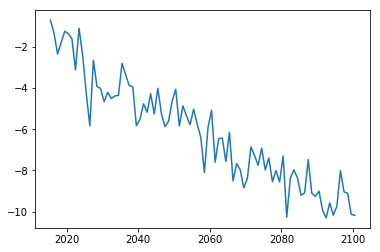

In [44]:
X=AmpPhase("evspsbl","NW")
Ann=dh.TOE("evspsbl","NW")
X.anomalize("ssp585")
phasedata=MV.average(ensemble_average_data(X.ssp585["phase_anom"]),axis=0)
Plotting.time_plot(phasedata)

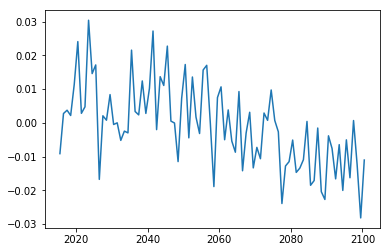

In [45]:
ampdata=MV.average(ensemble_average_data(X.ssp585["amp_anom"]),axis=0)
Plotting.time_plot(ampdata)

In [ ]:
test=MV.average(Ann.ensemble_average("ssp585"),axis=0)
test.shape